# Solver comparison

In this tutorial, we demonstrate how to compare geostatistical solvers using GeoStats.jl. This feature addresses a recurrent, sometimes underestimated, issue in the geostatistics community: the absence of scientific methods and software for rigorous selection of solvers and parameter sets.

As we will see, the ability to manipulate solvers as first-class objects can save us from exhausting, manual trial and error, and can definitely help us make better use of our time on a critical project with many time constraints.

Before we proceed, please install the following packages:

In [1]:
] add GeoStats InverseDistanceWeighting Plots PyPlot

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
 Installed InverseDistanceWeighting ─ v0.2.0
  Updating `~/.julia/environments/v1.0/Project.toml`
  [6a8e3230] + InverseDistanceWeighting v0.2.0
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [6a8e3230] + InverseDistanceWeighting v0.2.0


In [2]:
using Random; Random.seed!(2017); # make sure this tutorial is reproducible

## Problem definition

We start by creating a simple 2D estimation problem based on a given data set:

In [3]:
using GeoStats

geodata = readgeotable("data/permeability.csv", coordnames=[:x,:y])
domain  = boundgrid(geodata, (100,100))
problem = EstimationProblem(geodata, domain, :permeability)

2D EstimationProblem
  data:      500×3 GeoDataFrame (x and y)
  domain:    100×100 RegularGrid{Float64,2}
  variables: permeability (Float64)

Let's suppose that we want to compare Kriging and inverse distance weighting (a.k.a. IDW) on this problem. Suppose that we are also interested in comparing different variogram models in Kriging. We define the solvers:

In [4]:
using InverseDistanceWeighting

solver₁ = Kriging(:permeability => (variogram=ExponentialVariogram(range=40.),))
solver₂ = Kriging(:permeability => (variogram=SphericalVariogram(range=40.),))
solver₃ = InvDistWeight()

solvers = [solver₁, solver₂, solver₃]

┌ Info: Precompiling InverseDistanceWeighting [6a8e3230-34bb-5a86-b9da-9f7447a06da5]
└ @ Base loading.jl:1186


3-element Array{AbstractEstimationSolver,1}:
 Kriging      
 Kriging      
 InvDistWeight

and proceed to the comparisons.

## Visual comparison

Visual comparisons can be useful for quickly pruning solver/parameter combinations:

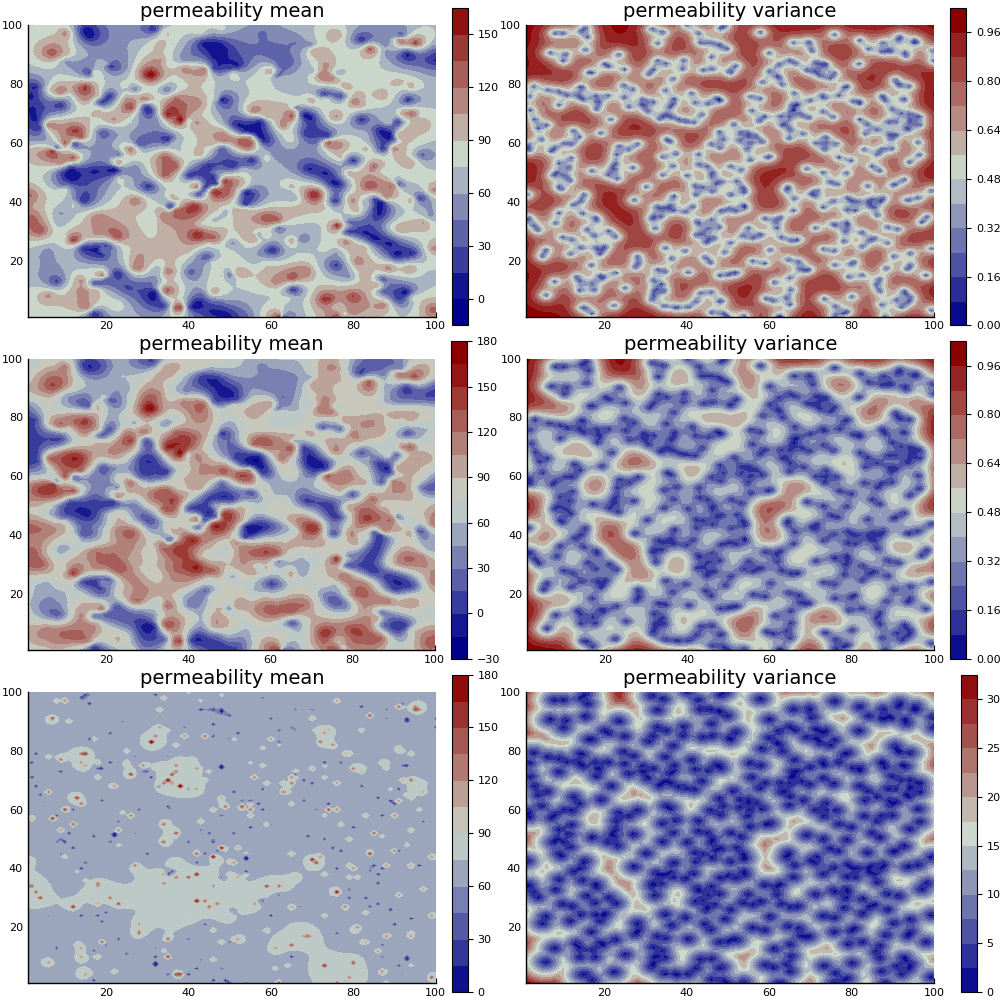

In [5]:
using Plots; pyplot(size=(1000,1000))

compare(solvers, problem, VisualComparison())

## Cross-validation

For quantitative comparisons, k-fold cross validation is a good option. We can plot the distribution of errors for each estimation solver and decide which is the best for the problem at hand based on summary statistics like the absolute mean validation error:

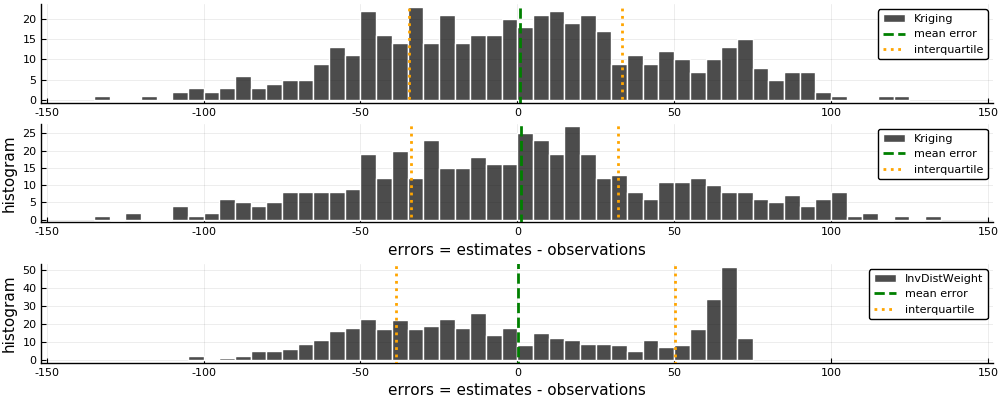

In [6]:
errors = compare(solvers, problem, CrossValidation(10))

plot(errors, bins=50, size=(1000,400))

We verify the unbiasedness property of Kriging estimators (mean of errors is zero). We also stress that choosing a solver simply based on the mean absolute validation error is not a good idea. Although in this example, all the solvers present mean of errors around zero, inverse distance weighting is overestimating permeability values at many locations of the domain (see the mode in the right side of the distribution).